# Assignment 1 - Linear Algebra


In this exercise, you will investigate various aspects of linear algebra.

* Use appropriate functions
* Comment your code.
* Use numpy/scipy libraries where appropriate, except where explicitly stated.

For each question where you are asked to write some code, you will also be asked to _briefly_ describe what you have done in a text cell below.  


## Q1

In this part you will need to use the matrix inversion code based on Cramer's rule, posted in the matrix-inversion notebook on Blackboard. Cut and paste the necessary functions into the cell below.

In [1]:
import numpy as np
import math
import scipy.linalg

def det2x2(m):
    if m.shape[0] != 2 or m.shape[1] != 2:
        raise Exception("Non2x2Matrix")
    
    return ( m[0][0]*m[1][1] ) - ( m[0][1]*m[1][0] )

def inverse2x2(m):
    if (m.shape[0] != 2 or m.shape[1] != 2):
        raise Exception("Non2x2Matrix")

    det = det2x2(m)
    tmp = np.empty([2,2])
    tmp[0][0] = m[1][1] / det
    tmp[0][1] = -1 * m[0][1] / det
    tmp[1][0] = -1 * m[1][0] / det
    tmp[1][1] = m[0][0] / det
    return tmp

def submatrix(m,i,j):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    # create a new matrix
    n = m.shape[0]-1
    tmp = np.empty([n,n])
    
    # get the indices of the matrix that will be used
    tmpi = list(range(m.shape[0]))
    del tmpi[i]
    tmpj = list(range(m.shape[1]))
    del tmpj[j]
    
    for ii in range(n):
        for jj in range(n):
            tmp[ii][jj] = m[tmpi[ii]][tmpj[jj]]

    return tmp

def det(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if (m.shape[0]==2):
        return det2x2(m)
        
    else:
        tmp = 0
        # use 0-th row to calculate determinant
        for j in range(m.shape[0]):
            tmp = tmp + (math.pow(-1,j) * m[0][j] * det(submatrix(m,0,j)))
    
    return tmp

def adjugate(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    tmp = np.empty(m.shape)
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            # note the order of indices below !
            tmp[j][i] = (math.pow(-1,i+j) * det(submatrix(m,i,j)))
    return tmp

def inverse(m):
    if not (m.shape[0] == m.shape[1]):
        raise Exception("NonSquareMatrix")
    
    if m.shape[0]==2:
        return inverse2x2(m)
    
    d = det(m)        
    c = adjugate(m)
    return np.true_divide(c,d)# use this cell for code

## 1a)
Verify that the code produces the correct result for a single _randomly_ generated 4x4 matrix. Make sure you account for possible rounding error due to limited floating point precision. 

In [2]:
a=np.random.rand(4,4) # make random 4x4 matrix
inv_a=inverse(a)      #perform inverse on it
inv_a_scipy=scipy.linalg.inv(a) #check with scipy function

print("Random matrix:\n",a)
print("Random matrix inverted by functions:\n", inv_a,"\n")
print("Random matrix inverted by scipy package:\n", inv_a_scipy)
assert(np.allclose( inv_a_scipy, inv_a, atol=1e-19)) #make sure rounding has no effect

Random matrix:
 [[0.78901358 0.39688613 0.76020753 0.86507272]
 [0.12527075 0.86657466 0.16435337 0.31185108]
 [0.28403105 0.57560234 0.96807159 0.80316401]
 [0.56007544 0.02522088 0.51482812 0.05909853]]
Random matrix inverted by functions:
 [[ 1.07907642  0.39769076 -1.38118423  0.87680017]
 [-0.46244118  1.40459269 -0.07490093  0.37529262]
 [-1.32944365 -0.42913011  1.51001523  1.20307959]
 [ 1.55222051 -0.63002661 -0.03285816 -2.02913096]] 

Random matrix inverted by scipy package:
 [[ 1.07907642  0.39769076 -1.38118423  0.87680017]
 [-0.46244118  1.40459269 -0.07490093  0.37529262]
 [-1.32944365 -0.42913011  1.51001523  1.20307959]
 [ 1.55222051 -0.63002661 -0.03285816 -2.02913096]]


## 1b)
Plot the cpu-time taken to solve a randomly generated simultaneous equation as a function of the matrix order N. Your plot should contain 3 lines, for each of the following methods :
1. the matrix inversion function above based on Cramer's rule
2. LU decomposition using scipy
3. SVD decomposition using scipy

Note that you will need to generate both a random NxN matrix, and a random set of solutions. You will need to think about how you're going to handle errors (eg. if you generate a random matrix that is singular). You will need to look up the LU and SVD decomposition routines in the scipy reference manual (https://docs.scipy.org/doc/scipy/reference/), and make sure that your treatment of each routine is "fair", i.e. performs the same calculation.

You may want to read up on these methods in Numerical Recipes. The 3rd edition is available free online at http://numerical.recipes/oldverswitcher.html. LU decomposition is on p48 and SVD decomposition is on p65 in this edition.

Finally, write a paragraph describing your code in the text cell below : how you designed the code, what choices you had to make, and why - in particular how you deal with the issues raised above.

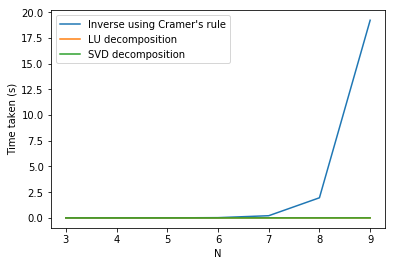

In [3]:
%matplotlib inline

import time
import matplotlib.pyplot as plt

def soln(inv,r):
    return inv.dot(r) #x=inv_A.b

def timetaken(start,end):
    """Calculate time taken for process given the start and end times"""
    return end-start

def lu_y(b,l):
    """Calculate the y vector using the randomly generated solutions
    and lower triangular matrix to get y=Ux"""
    y=[]
    for i in range(len(b)):
        sum=0
        for j in range(i):
            sum+=l[i][j]*y[j]
        y.append((b[i]-sum)/l[i][i])
    return np.array(y)

def lu_x(r,p,l,u):
    """Calculate x from the decomposed matrix and random solutions, first
    by finding y then using the upper triangular matrix to find x"""
    p_t=np.transpose(p)
    b=p_t.dot(r) #lux = b
    N=len(r)
    
    my_y=lu_y(b,l)
    x=np.zeros(N)
    x[N-1]=my_y[N-1]/u[N-1][N-1]
    
    for i in range(N-2,-1,-1):
        sum=0
        for j in range(N-1,i,-1):
            sum+=u[i][j]*x[j]
        x[i]=(my_y[i]-sum)/u[i][i]
    
    return x

def svd_x(r,U,s,vh):
    """Calculate x using the SVD decomposed matrix by 
    applying matrices to the random solutions"""
    U_T=np.transpose(U)
    s_inv=scipy.linalg.inv(np.diag(s))
    V=np.transpose(vh)
    A=np.matmul(s_inv,U_T)
    B=np.matmul(V,A)
    x=np.matmul(B,r)
    return x

def is_invertible(a):
    """makes sure the matrix is square and invertible (not singular)
    by checking that rows are not linear combinations of others"""
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

time1,time2,time3,N_vals=[],[],[],[] #creating empty lists to be appended and plotted

for N in range(3,10):
    while True:
        try:
            a=np.random.rand(N,N) #create random square matrix
            if is_invertible(a)==True:
                break
            else:
                raise ValueError
        except ValueError:
            print("singular matrix generated")
    
    r=np.random.rand(N,1)   #create random list of solutions
    
    start1=time.time()        #begins timing the first method of solving
    inv_a1=inverse(a)         
    x1=soln(inv_a1,r)         #solves using cramer's rule
    end1=time.time()
    time1.append(timetaken(start1,end1))
    
    start2=time.time()
    p,l,u=scipy.linalg.lu(a,permute_l=False)
    x2=lu_x(r,p,l,u)                         #solves using lu decomposition
    end2=time.time()
    N_vals.append(N)                       #adds this value of N to the list to be plotted
    time2.append(timetaken(start2,end2))
    
    start3=time.time()
    U,s,vh=scipy.linalg.svd(a)
    x3=svd_x(r,U,s,vh)                   #solves using svd decomposition
    end3=time.time()
    time3.append(timetaken(start3,end3))
    
plt.plot(N_vals,time1,label="Inverse using Cramer's rule")
plt.plot(N_vals,time2,label="LU decomposition")
plt.plot(N_vals,time3,label="SVD decomposition")           #plot all 3 methods computation times on same axis
plt.legend()
plt.xlabel("N")
plt.ylabel("Time taken (s)")
plt.show()

Firstly, algorithms were written for each method of solving the system of equations. They were then tested to make sure that each method was actually finding the solution and that the solutions were the same for each method. Times were defined at the start and end of each method, the difference being the time taken for that method, these were put in 3 seperate lists (one for each method). Another list was also made, and filled with the N values (the size of the random matrix). Finally, these lists were plotted in the figure that gets outputted. In this part the rounding errors don't matter since the results aren't actually outputted, we only require that they have been computed. 

The matrix is required to be singular by checking that its rows are not linear combinations of each other. It is unlikely given the randomness but has been ruled out anyway. If a matrix is found to be singular, the while loop will restart and another matrix will be created. The matrix also must be square and this is also checked to remove errors.

## 1c)
Now discuss the results you obtained above. Can you explain the results in terms of the number of operations performed by each function ?  You might want to look up the **computational complexity** of these algorithms.  How well do the curves conform to your explanation ?

### Time complexity for the algorithms
The Cramer's rule function for $N$ higher than 3 takes significantly longer than the methods using decomposition. This makes sense since this function has to compute $N+1$ determinants to invert the matrix as well as do checks on each matrix to see whether they are square. Cramer's rule is of time complexity $O(n!\times n)$ so the computing time diverges from 0 very quickly with increasing $N$.

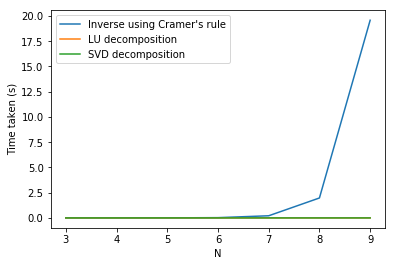

Including all 3 methods shows that LU and SVD decompositions for solving the equations are much faster. If the Cramer's rule method is removed and the range of $N$ values increased up to 50, it can be seen that the time taken for the other two methods is increasing steadily with $N$.

SVD decomposition and LU decomposition have time complexity $O(n^3)$, which diverges from 0 more slowly than $O(n! \times n)$. This makes sense because it can be seen that Cramer's rule takes much longer even for $N>3$.

Setting the range of $N$ to even higher (500) and not including Cramer's rule, the graph for each method seems to have a cubic relationship with different coefficients. This fits with the theory since both methods have time complexity $O(n^3)$. Specifically, LU decomposition has a time complexity $\frac{2}{3}n^3$ and SVD decomposition has time complexity $3n^3$. These are merely the complexity for the decompositions, however. The program must then also solve the system of equations. Both methods require computation of $N$ results through simple linear equations, however the computation of solutions for LU decomposition has to be iterated causing it to take longer. This means that SVD decomposition should be seen to be faster so the result seen for time taken makes sense.

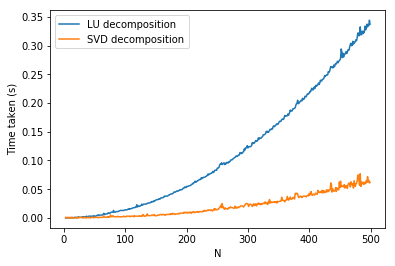

This graph does seem to show deviation from the expected cubic at the higher $N$ values (close to 500). This may be due to an anomalous time taken, as a result of the random matrix being more difficult to decompose.  There is a lot of variation in time at higher $N$ values, but the same general trend. This implies that there are some values for $N$ that are harder to decompose. An attempt to observe this was made by examining a small range of high $N$ values, however there was no consistency in which $N$ produced higher times.

# 1d)
Next, we will study the precision of the algorithms - in particular, for near singular matrices. Write a routine that will estimate (and plot) the precision of the result when solving the equation below, for small values of k. Your function should do this for all 3 routines studied in Q1b).

\begin{eqnarray*}
x + y + z & = & 5 \\
x + 2y - z & = & 10 \\
2x + 3y +kz & = & 15 
\end{eqnarray*}

You will need to choose a method to estimate the precision, given that the equation solvers will return values for all of x, y, and z.

As before, describe the functionality of the code and the choices you made writing it in the text cell below.

Range of x values for Cramer's rule method: 1.4901161193847656e-08
Range of x values for LU decomposition method: 0.0
Range of x values for SVD decomposition method: 2.0489096641540527e-08


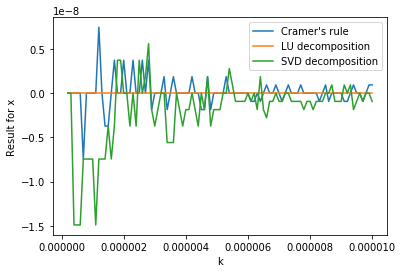

In [4]:
k_vals,x1_vals,x2_vals,x3_vals=[],[],[],[] #empty lists to be appended and plotted
for i in range(100,1,-1):
    k=i*1E-7                 #for a range of small k values
    k_vals.append(k)
    a=np.array([[1,1,1],[1,2,-1],[2,3,k]])
    r=np.array([5,10,15])
    
    inv_a1=inverse(a)
    x1=soln(inv_a1,r)         #solves the system of equations using  cramer's rule
    x1_vals.append(x1[0])

    p,l,u=scipy.linalg.lu(a,permute_l=False)
    x2=lu_x(r,p,l,u)                          #solves the system of equations using lu decompostion
    x2_vals.append(x2[0])
    
    U,s,vh=scipy.linalg.svd(a)
    x3=svd_x(r,U,s,vh)               #solves the system of equations using svd decomposition
    x3_vals.append(x3[0])

print("Range of x values for Cramer's rule method:",max(x1_vals)-min(x1_vals))
print("Range of x values for LU decomposition method:",max(x2_vals)-min(x2_vals))
print("Range of x values for SVD decomposition method:",max(x3_vals)-min(x3_vals))    
plt.plot(k_vals,x1_vals,label="Cramer's rule")
plt.plot(k_vals,x2_vals,label="LU decomposition")
plt.plot(k_vals,x3_vals,label="SVD decomposition")
plt.xlabel("k")                                       #plot the x values for each method at different k values
plt.ylabel("Result for x")
plt.legend()
plt.show()

The program calculates the solutions to the equations given for a range of small k values. It then plots the solution for x at each value of k for each method. Again rounding was not taken into account as the point of this is to see the variation in results from the methods.

## 1e)
Discuss your results in the test box below. You should describe the behaviour of each algorithm as k goes to 0, and explain what is happening in each case. How would these results affect your choice of algorithm ?

### Prescision and behaviour of algorithms at small $k$
The precision was tested by examining the result for the $x$ solution for low values of $k$, which should be 0 independant of $k$.

As the value of $k$ goes to 0, the Cramer's rule algorithm has increasing variation of results for the $x$ value computed. The LU decomposition has no variation throughout and consistently gives a value of 0. The SVD decomposition has increasing variations with higher amplitudes than the deviations seen for Cramer's rule, as $k$ goes to 0. This is shown by the outputted graph:

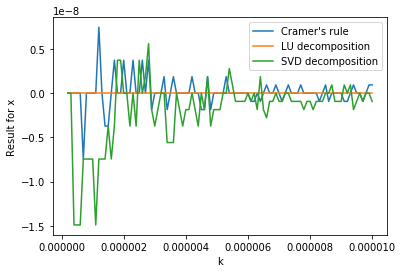

The precision was also tested at higher $k$ values between 0 and 1, the following graph was obtained:

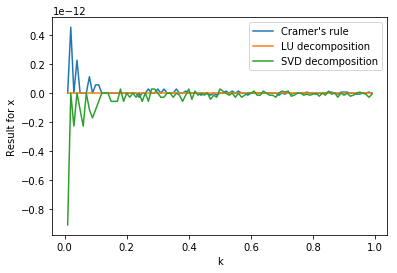

The lowest value of $k$ in this graph was 0.01 and as expected the amplitude of the deviations from 0 are smaller than in the graph with smaller $k$ values. The same trend is also shown: the SVD and Cramer's rule algorithms have greater deviation for lower $k$ values.

These results imply that LU decompstion is the best method as it gives very high precision of results for small $k$ values. However, for higher $N$ it will take longer than SVD so it may be more useful to use SVD decomposition at very high $N$.

## Q2
This question is on eigenvalue problems.  

## 2a)
In this part you should write a function that will find the eigenvector/eigenvalues of a matrix A using "Rayleigh quotient iteration". The algorithm is as follows :

1. An initial values for the eigenvalue $\mu_0$ and eigenvector $b_0$ must be supplied

2. The next approximation of the eigenvector is given by :
$$b_{i+1} = \frac{(A-\mu_i I)^{-1}b_i}{|(A-\mu_i I)^{-1}b_i|}$$

3. The corresponding eigenvalue is given by :

$$\mu_{i+1} = \frac{b^*_{i+1}Ab_{i+1}}{b^*_{i+1}b_{i+1}}$$

4. Now iterate steps 2 and 3 until convergence is reached for a specified precision, ie.
$$\mu_{i+1} - \mu < a_{tol}$$

(Note that the numerator in 2. can also be found by solving $(A-\mu_i I)x = b$) 

Your function should take arguments for the matrix A, the initial estimates of eigenvalue and eigenvector, and the precision required (ie. a convergence condition).

You should use vector and matrix algebra routines from numpy and scipy.linalg for the operations described above.

Explain the choices you made when writing this code in the text cell below.

In [5]:
def rayleigh(A,mu_0,b_0,a_tol):
    """Function that, given an initial eigenvector and eigenvalue guess, computes
    an eigenvalue and corresponding eigenvector using the Rayleigh quotient
    iteration method"""
    mu_new=mu_0
    b_new=b_0
    mu_prev=0
    while abs(mu_new-mu_prev) > a_tol:
        mu_prev=mu_new
        mu_new= np.conj(b_new).dot(np.matmul(A,b_new))/np.conj(b_new).dot(b_new)
        b_new = scipy.linalg.inv(A - mu_new*np.identity(A.shape[0])).dot(b_new)/np.linalg.norm(scipy.linalg.inv(A - mu_new*np.identity(A.shape[0])).dot(b_new))
    
    return b_new,mu_new
        

A way of looping needed to be defined so that if the previous and new eigenvalues were a certain amount apart, the function would loop again to refine the eigenvalue. Each loop the function finds a new eigenvector and value based on the Rayleigh quotient iteration algorithm. Once the loop stops these are outputted. The function works for any size matrix as long as the $b_0$ defined is the same size, it creates the identity used in the first step based on the size of the given matrix $A$.

### 2b)
Now test your function using a matrix with known eigenvalues / vectors. You can use :
$$\left(\begin{array}{ccc} 1 & 2 & 3 \\ 1 & 2 & 1 \\ 3 & 2 & 1 \end{array}\right)$$

The leading eigenvalue of this matrix is $\sqrt{5}+3$, which corresponds to the eigenvector :
$$\left(\begin{array}{c} 1 \\ \frac{\sqrt(5)-1}{2} \\ 1 \end{array}\right)$$

In [6]:
A=np.array([[1,2,3],[1,2,1],[3,2,1]]) #matrix given
mu_0=200                            #initial eigenvalue guess
b_0=np.array([1,1,1])               #initial eigenvector guess
a_tol=1E-19                         #required precision between final and previous eigenvalue
print(rayleigh(A,mu_0,b_0,a_tol)) 

(array([0.64793616, 0.40044657, 0.64793616]), 5.23606797749979)


## 2c)
Your function should find one eigenvalue of a Hermitian (or real symmetric) matrix, along with it's corresponding eigenvector. Can you think of a method to find the other eigenpairs ?  Can you use the fact that the eigenvectors of a real symmetric matrix are orthogonal ? Discuss a possible algorithm to find further eigenpairs in the text box below, and use the code cell below if you want to write some code to demonstrate your answer. 

### Solving for other eigenpairs:
The Rayleigh quotient method can be used with a deflation algorithm to find other eigenpairs of the same matrix. The deflation algorithm decreases the initial matrix $A$ and creates a new matrix $B$ given by:

$$B=A-\lambda_1 v^Tv,$$

where $\lambda_1$ is the first eigenvalue and $v$ is its corresponding eigenvector. This makes the first eigenvalue 0 in the new matrix so another is the leading value. If the Rayleigh quotient iteration algorithm is run on this new matrix a new eigenpair should be found.

This didn't work on its own as expected. The initial eigenvector guess also had to be changed so that the signs were the same as the next eigenvector. Doing this gave the correct result for the second eigenpair. 

Similarly, the third eigenpair can be found by again changing the initial guess and deflating the matrix.

Another function was defined to try different $b_0$ and deflate the matrix given when it finds an eigenpair. This function should find all eigenpairs then return them. It works well for the matrix defined in the previous method:

$$A=\left(\begin{array}{ccc} 1 & 1 & 1 \\ 1 & 2 & 2 \\ 1 & 2 & 3 \end{array}\right),$$

and some other matrices. However it can just get stuck, so nothing is ever outputted. I tried to avoid this by putting a timeout condition in the code but it didn't work, implying that it is stuck doing the rayleigh function certain matrices. The is likely due to the rayleigh function not being able to converge.

In [7]:
def deflate(A,l1,u):
    """Deflates given matrix A so that the first leading eigenvalue is 0
    and the second eigenvalue becomes the leading one"""
    X=np.outer(u,u)
    #print(X)
    B=A-(l1*X)
    B[np.abs(B) < 1e-14] = 0
    return B

A=np.array([[1,1,1],[1,2,2],[1,2,3]])
mu_0=10                           #initial eigenvalue guess
b_0=(1/np.sqrt(3))*np.array([1,1,1])               #initial eigenvector guess
a_tol=1E-12                         #required precision between final and previous eigenvalue
u,l1=rayleigh(A,mu_0,b_0,a_tol)     
print(u,l1)                           #find and print first eigenpair
B=deflate(A,l1,u)                  #deflate original matrix
b_0=(1/np.sqrt(3))*np.array([1,1,-1])  #new initial eigenvector guess
v,l2=rayleigh(B,mu_0,b_0,a_tol)      
print(v,l2)                          #find and print second eigenpair
C=deflate(B,l2,v)                  #deflate original matrix
b_0=(1/np.sqrt(3))*np.array([-1,1,-1])  #new initial eigenvector guess
w,l3=rayleigh(C,mu_0,b_0,a_tol)      
print(w,l3)                          #find and print second eigenpair

[-0.32798528 -0.59100905 -0.73697623] 5.048917339522306
[-0.73697623 -0.32798528  0.59100905] 0.6431041321077907
[ 0.59100905 -0.73697623  0.32798528] 0.3079785283699041


In [8]:
def rayleigh2(A,b_0):
    """Function that, given an initial eigenvector, computes
    an eigenvalue and corresponding eigenvector using the Rayleigh quotient
    iteration method"""
    mu_0=200
    a_tol=1E-19
    mu_new=mu_0
    b_new=b_0
    mu_prev=0
    while abs(mu_new-mu_prev) > a_tol:
        mu_prev=mu_new
        mu_new= np.conj(b_new).dot(np.matmul(A,b_new))/np.conj(b_new).dot(b_new)
        b_new = scipy.linalg.inv(A - mu_new*np.identity(A.shape[0])).dot(b_new)/np.linalg.norm(scipy.linalg.inv(A - mu_new*np.identity(A.shape[0])).dot(b_new))
    
    return b_new,mu_new

def eigenpairs(A):
    """By trying lots of different initial vectors and deflating the matrix when a pair is found
    attempts to find all eigenpairs for a given matrix"""
    eigenvector_list=[]
    eigenvalue_list=[]
    timeout = time.time() + 5
    while len(eigenvalue_list)<3:
        if time.time()>timeout:         #should mean the program times out and outputs whatever has been found but doesn't work, implies something is taking a long time for some matrices
            break
        for i in range(-1,3,2):
            for j in range(-1,3,2):
                for k in range(-1,3,2):
                    b_0=(1/np.sqrt(3))*np.array([i,j,k])
                    v,l=rayleigh2(A,b_0)
                    if round(l,2) not in [round(elem,2) for elem in eigenvalue_list] and len(eigenvalue_list)!=3: #checks if eigenvalue has been found yet
                        eigenvector_list.append(v)
                        eigenvalue_list.append(l)
                        if time.time()>timeout:         #should mean the program times out and outputs whatever has been found but doesn't work, implies something is taking a long time for some matrices
                            break
                        if len(eigenvalue_list)==1:
                            A=deflate(A,eigenvalue_list[0],eigenvector_list[0])
                        elif len(eigenvalue_list)==2:
                            A=deflate(A,eigenvalue_list[1],eigenvector_list[1])
                        else:                                                      #if one pair is found, deflate the matrix and loop again
                            break
        
    return eigenvector_list,eigenvalue_list

while True:
        try:
            A=np.array([[1,1,1],[1,2,2],[1,2,3]]) #matrix given
            print(eigenpairs(A))                  #find eigenpairs
            if is_invertible(A)==True:
                break                   #test if A is singular
            else:
                raise ValueError
        except ValueError:
            print("singular matrix generated")
            break

([array([-0.32798528, -0.59100905, -0.73697623]), array([-0.73697623, -0.32798528,  0.59100905]), array([ 0.59100905, -0.73697623,  0.32798528])], [5.048917339522306, 0.6431041321077907, 0.307978528369904])


## Q3

For this question you should write a function that will find the eigenvalues of the coupled system of oscillators shown below.

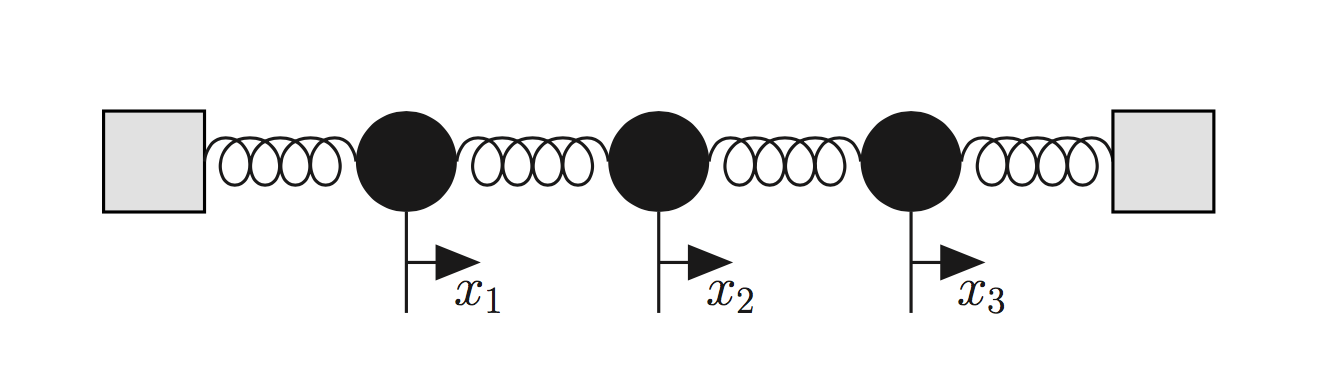

If the displacement of the $i$th mass from its equilibrium position is denoted as $x_i$, the force on the mass is given by the tension in the two springs as :

$$F_i = −k(x_i − x_i−1) + k(x_i+1 − x_i) = −k(2x_i − x_i−1 − x_i+1)$$

We can assume that there are normal mode solutions, i.e. solutions of the form $x_i = z_i e^{i\omega t}$ in which all masses oscillate with the same frequency $\omega$ but with unknown phasors $z_i$. Then the above equation becomes :

$$F_i = m\ddot{x}_i = −m\omega^2x_i = −k(2x_i − x_i−1 − x_i+1)$$

This is one row of a matrix equation describing the entire system :

$$m\omega^2x_i \left(\begin{array}{c} \vdots \\ \\ x_i \\ \\ \vdots \end{array}\right) = 
\left(\begin{array}{ccccccc} & & & \vdots & & & \\ \cdots & 0 & -1 & 2 & 1 & 0 & \cdots \\ & & & \vdots & & & \end{array}\right)
\left(\begin{array}{c} \vdots \\ x_{i-1} \\ x_i \\ x_{i+1} \\ \vdots \end{array}\right)
$$

This example is a typical eigenvalue problem, in that many of the matrix elements are zero, which can greatly simplify the computational challenge and make even large systems solvable.

## 3a)
Write a function in the cell below that will calculate the normal modes and corresponding oscillation frequencies for a system of three identical masses connected by identical springs as shown above.

As for previous questions, briefly describe how your code works and the choices you made when writing it in the text cell below.

In [9]:
A=np.array([[-2,1,0],[1,-2,1],[0,1,-2]]) #system of 3 masses matrix
w,v=np.linalg.eig(A)                     #find eigenpairs
print("Normal modes are:\n")             #print each mode
for i in range(len(w)):
    print("n",i+1, "= [x1,x2,x3] = C","[",round(v[:,i][0],4),round(v[:,i][1],4),round(v[:,i][2],4),"] e^(iwt) with w =",round(np.sqrt(abs(w[i])),4),"\n")


Normal modes are:

n 1 = [x1,x2,x3] = C [ 0.5 -0.7071 0.5 ] e^(iwt) with w = 1.8478 

n 2 = [x1,x2,x3] = C [ 0.7071 -0.0 -0.7071 ] e^(iwt) with w = 1.4142 

n 3 = [x1,x2,x3] = C [ 0.5 0.7071 0.5 ] e^(iwt) with w = 0.7654 



The matrix for this system of masses was given to the program. The eigenvalues and vectors were then found corresponding to the frequency and relative amplitudes for each mode. Each mode is then printed.

## 3b)
Discuss your results above. Describe the physical interpretation of each mode you have found ? How does the behaviour change if the springs at either end are removed ?

### Normal Modes Discussion, representation and animation:
The code in the cell above gives the normal modes for the given system of masses. The first normal mode describes the outer masses travelling in the same direction and the middle travelling in the opposite direction. This mode has a frequency of $1.8478\ rad\ s^{-1}$ so each mass completes one oscillation in $3.4\ s$.

The second mode describes the middle mass remaining stationary and the other masses moving in opposite directions. With a slightly lower frequency of $1.4142\ rad\ s^{-1}$.

The last mode describes all masses moving in the same direction but with a lower frequency of $0.7654\ rad\ s^{-1}$. All of these modes are demonstrated by the code below which outputs an animation for a chosen mode, setting $C=0$. They are also shown by the image below.

<div>
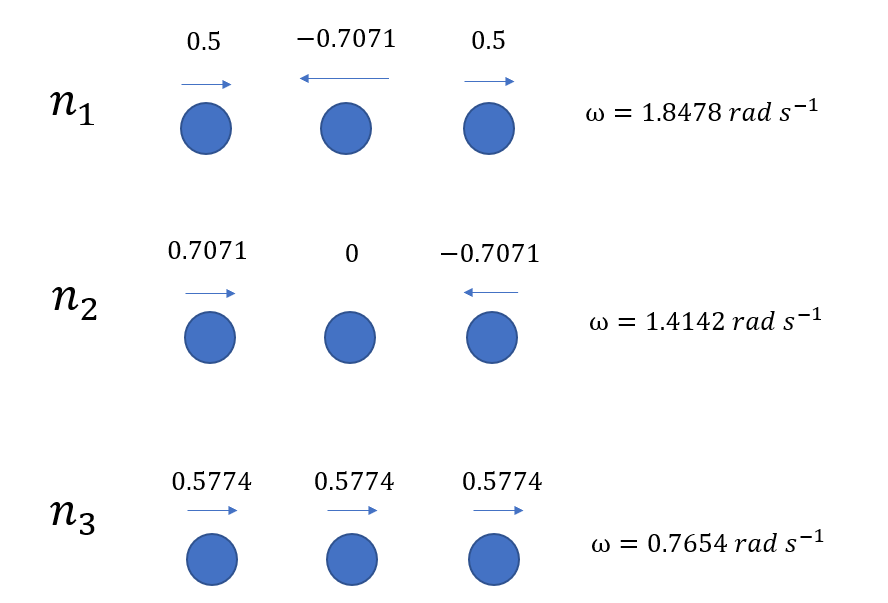
</div>

If the springs attatched to the wall are removed then the force on the end masses changes. The resulting modes are given by the equations:

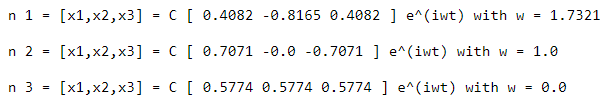

These are shown by the code for the animations and by the image below.

<div>
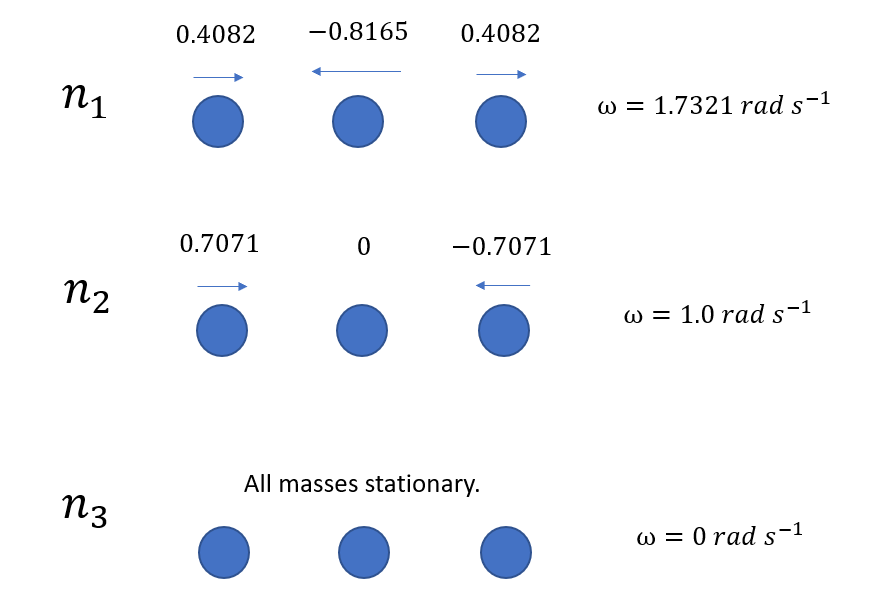
</div>

In [10]:
%matplotlib qt

while True:
    try:
        MyInput = str(input("Would you like to see:\na)System attatched to walls\nb)Not attatched to walls"))
        if MyInput in "ab":
            break
        else:
            raise ValueError
    except ValueError:
        print("Please select an option.")

if MyInput=="a":
    A=np.array([[-2,1,0],[1,-2,1],[0,1,-2]]) #system of 3 masses matrix
else:
    A=np.array([[-1,1,0],[1,-2,1],[0,1,-1]]) #system of 3 masses matrix

w,v=np.linalg.eig(A)
    
while True:
    try:
        MyInput = str(input("Which normal mode would you like to see:\na)n1\nb)n2\nc)n3\nq)quit"))
        if MyInput in "abcq":
            break
        else:
            raise ValueError
    except ValueError:
        print("Please select an option.")

while True:
    if MyInput=="q":
        break
    else:
        if MyInput=="a":
            j=0
        elif MyInput=="b":
            j=1
        else:
            j=2            #defines which normal mode being animated
        t_vals,x1_vals,x2_vals,x3_vals=[],[],[],[]
        for i in range(1000):
            t=0.01*i
            t_vals.append(t)
            x1_vals.append(-2+(v[:,j][0]*np.cos(w[j]*t)))
            x2_vals.append(v[:,j][1]*np.cos(w[j]*t))
            x3_vals.append(2+(v[:,j][2]*np.cos(w[j]*t))) # add new postions and time to lists
        try:
            for i in range(len(t_vals)):
                plt.clf() #clear the plot
                plt.axis([-5,5,-5,5]) #set axis
                Circle=plt.Circle((x1_vals[i],0), radius=0.2, color="blue", fill=True)
                Circle2=plt.Circle((x2_vals[i],0), radius=0.2, color="blue",  fill=True)
                Circle3=plt.Circle((x3_vals[i],0), radius=0.2, color="blue", fill=True) # plot circles at new positions each iteration
                plt.gca().add_patch(Circle)
                plt.gca().add_patch(Circle2)
                plt.gca().add_patch(Circle3)
                plt.gca().ticklabel_format(style='sci', scilimits=(0,1))
                plt.show()
                plt.pause(0.000000000001) # slight pause then loops, gives animated plot
        except KeyboardInterrupt:
            pass #should stop animation if keyboard interupts but sometimes doesnt work and sometimes crashes
        break

Would you like to see:
a)System attatched to walls
b)Not attatched to wallsb
Which normal mode would you like to see:
a)n1
b)n2
c)n3
q)quit1
Please select an option.
Which normal mode would you like to see:
a)n1
b)n2
c)n3
q)quitq
